Tutorial URL: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

# Classifying Names with a Character-Level RNN

In [1]:
# preamble 
from io import open
import unicodedata
import glob
import string
import re
import random
import os
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
data_folder = "../../../data/pytorchTutorials/data/names"

files = glob.glob(data_folder + '/[A-Z][A-Za-z]*.txt')
# print(files)
print(len(files))

18


In [3]:
# all_letters is a string composed of alphabets (lower, upper), spac and .,;
all_letters = string.ascii_letters + " .,;'"
letter_to_index = {k:v for v,k in enumerate(all_letters)}
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
# Mn means mark-nonspacing. Accents belong to this category
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# s = u'What are ? you .!?-_^&* doing - in vikas-bahriwani. Málaga'
# unicodeToAscii(s)
# Output: 'What are  you . doing  in vikasbahriwani. Malaga'

In [4]:
# reading files and creating dictionary
# dictionary is called category for extensibility of the code that comes later

def read_files(filenames):
    category_lines = {}
    all_categories = []
    
    for filename in filenames:
        category = os.path.splitext(filename)[0].split('/')[-1]
        all_categories.append(category)
        with open(filename, encoding='utf8') as file:
            lines = file.read().strip().split('\n')
            lines = [unicodeToAscii(line) for line in lines]
            category_lines[category] = lines

    return category_lines, all_categories

In [5]:
category_lines, all_categories = read_files(files)
# print(category_lines)
print(all_categories)
n_categories = len(all_categories)
print(n_categories)
print(category_lines['Italian'][:5])

['Spanish', 'Korean', 'Italian', 'German', 'Irish', 'Vietnamese', 'Arabic', 'Greek', 'Chinese', 'English', 'Polish', 'Japanese', 'Russian', 'French', 'Scottish', 'Portuguese', 'Dutch', 'Czech']
18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [6]:
# converting a given line aka word aka name to a tensor
# len(line) x 1 x n_letters
# the tutorial uses the middle dimension as batch which is odd lets see if we can change that to first dimension

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters, device=device)
    for index, letter in enumerate(line):
        tensor[index,0,letter_to_index[letter]] = 1
    
    return tensor

In [7]:
# RNNPrescribed is the RNN as prescribed in the tutorial. It has the following characteristics:
# LogSoftmax
# Linear Layers, no non-linearities
# Note: The tutorial expects output to be based on input+hidden but I think that was a mistake 
# The textbook example of RNN is output = LogSoftmax(newly computed hidden)
# so that's how we will implement this class.
class RNNPrescribed(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, allow_bias = False):
        super(RNNPrescribed, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size, allow_bias)
        self.h2o = nn.Linear(hidden_size, output_size, allow_bias)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input, previous_hidden):
        combined = torch.cat((input, previous_hidden), dim = 1)
        hidden = self.i2h(combined)
        logits = self.h2o(hidden)
        log_probabilities = self.softmax(logits)
        
        return log_probabilities, logits, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size, device=device)

In [8]:
# RNNMine is my RNN implementation as learned in CS224N. It has the following characteristics:
# Regular softmax is used. Logits returned can be used with Cross Entropy loss
# Linear Layers with ReLU non linearity
# Though one can use ReLU as a layer (nn.ReLU) or from torch.nn.functional 
# - we will use the latter for it makes more sense from how we have seen it in theory
# - It that should not make much of a difference in results
class RNNMine(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, allow_bias = False):
        super(RNNMine, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size, allow_bias)
        self.h2o = nn.Linear(hidden_size, output_size, allow_bias)
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, input, previous_hidden):
        combined = torch.cat((input, previous_hidden), dim = 1)
        z_t = self.i2h(combined)
        h_t = F.relu(z_t)
        logits = self.h2o(h_t)
        probabilities = self.softmax(logits)
        
        return probabilities, logits, h_t
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size, device=device)

In [9]:
# use these lines to test code with one example

# hidden_size = 128
# rnn = RNNPrescribed(n_letters, hidden_size, n_categories)
# input = line_to_tensor("Vikas")
# previous_hidden = torch.zeros(1, hidden_size)

# prob, logits, hidden = rnn.forward(input[0], previous_hidden)
# print(prob)
# print(logits)
# print(hidden)

# input = line_to_tensor("Vikas")
# previous_hidden = torch.zeros(1, hidden_size)

# def passthrough(x):
#     return x

# rnn2 = RNNMine(n_letters, hidden_size, n_categories)
# prob, logits, hidden = rnn2.forward(input[0], previous_hidden)
# print(prob)
# print(logits)
# print(hidden)

In [10]:
def categories_from_probabilities(probabilities):
    elements, indices = torch.topk(probabilities, 1)
    index = indices[0].item()
    category = all_categories[index]
    
    return category, index

In [11]:
# Helper functions to get training examples easily. 
# This could be more efficient but 
def random_choice(input_list):
    """Returns random index from the list and corresponding element"""
    
    random_index = random.randint(0, len(input_list) -1)
    return random_index, input_list[random_index]

def random_training_example():
    category_index, category = random_choice(all_categories)
    _,line = random_choice(category_lines[category])
    category_tensor = torch.tensor([category_index], dtype = torch.long, device = device)
    line_tensor = line_to_tensor(line)
    
    return category, line, category_tensor, line_tensor

In [12]:
LEARNING_RATE = 0.005
HIDDEN_SIZE = 128

# think of criterion as instance of loss function
# default reduction is element_wise mean i.e. avg over all classes
criterion_prescribed = nn.NLLLoss()
criterion_mine = nn.CrossEntropyLoss()

def train(category_tensor, line_tensor, rnn):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    
    for li in range(line_tensor.size()[0]):
        probabilities, logits, hidden = rnn(line_tensor[li], hidden)
      
    if rnn is RNNPrescribed:
        loss = criterion_prescribed(probabilities, category_tensor)
    else:
        loss = criterion_mine(logits, category_tensor)
        
    loss.backward()
    
    # TODO: See if using optim makes a difference?
    # e.g. initialize optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
    # then instead of the following do optimizer.step()
    with torch.no_grad():
        for param in rnn.parameters():
            param -= LEARNING_RATE * param.grad
            
    return probabilities, loss.item()
        
    

In [14]:
n_iters = 100000
print_every = 5000
plot_every = 1000

#rnn = RNNPrescribed(n_letters, HIDDEN_SIZE, n_categories)
rnn = RNNMine(n_letters, HIDDEN_SIZE, n_categories).to(device)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    probabilities, loss = train(category_tensor, line_tensor, rnn)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categories_from_probabilities(probabilities)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.8672 Lemieux / Greek ✗ (French)
10000 10% (0m 11s) 2.1172 O'Hagan / Irish ✓
15000 15% (0m 17s) 3.3798 Duchamps / Greek ✗ (French)
20000 20% (0m 23s) 2.0927 Lemieux / English ✗ (French)
25000 25% (0m 28s) 0.9934 Delgado / Portuguese ✓
30000 30% (0m 34s) 1.2922 Cao / Chinese ✗ (Vietnamese)
35000 35% (0m 40s) 1.2930 Dempko / Polish ✗ (Czech)
40000 40% (0m 46s) 2.0101 Coma / Spanish ✗ (Czech)
45000 45% (0m 52s) 0.4070 Donndubhan / Irish ✓
50000 50% (0m 57s) 0.0584 Hadad / Arabic ✓
55000 55% (1m 3s) 1.5741 Knopp / Czech ✗ (German)
60000 60% (1m 9s) 1.7904 Shaw / Chinese ✗ (Scottish)
65000 65% (1m 15s) 0.3722 Wilson / Scottish ✓
70000 70% (1m 20s) 0.2933 Whyte / Scottish ✓
75000 75% (1m 26s) 1.4994 Appleton / English ✓
80000 80% (1m 32s) 0.3939 Dubicki / Polish ✓
85000 85% (1m 38s) 0.1812 Bonheur / French ✓
90000 90% (1m 43s) 2.2443 Pfaff / English ✗ (German)
95000 95% (1m 49s) 0.9709 Araullo / Portuguese ✗ (Spanish)
100000 100% (1m 55s) 0.2988 Gomulka / Polish ✓


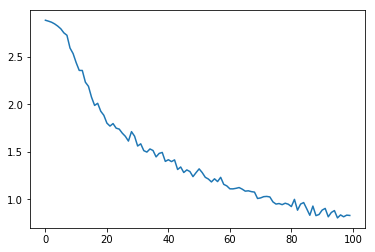

In [15]:
plt.figure()
print(plt.plot(all_losses))

In [16]:
def evaluate(category_tensor, line_tensor, rnn):
    hidden = rnn.init_hidden()

    for li in range(line_tensor.size()[0]):
        probabilities, logits, hidden = rnn(line_tensor[li], hidden)
            
    return probabilities

In [ ]:
confusion = torch.zeros(n_categories, n_categories, device = device)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    probabilities = evaluate(category_tensor, line_tensor, rnn)
    actual_index = category_tensor.item()
    predicted_text, predicted_index = categories_from_probabilities(probabilities)
    
    confusion[actual_index][predicted_index] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

In [ ]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()